## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
print(nltk_data[:20])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# splitting the data into train and test set (95:5)
train_set, test_set = train_test_split(nltk_data,test_size=0.05, random_state=40)

print(len(train_set))
print(len(test_set))
print(train_set[:20])

3718
196
[[('Why', 'ADV'), ('are', 'VERB'), ('programs', 'NOUN'), ('like', 'ADP'), ('this', 'DET'), ('not', 'ADV'), ('eliminated', 'VERB'), ('*-2', 'X'), ('*T*-1', 'X'), ('?', '.')], [('``', '.'), ('Many', 'ADJ'), ('in', 'ADP'), ('the', 'DET'), ('United', 'NOUN'), ('States', 'NOUN'), (',', '.'), ('including', 'VERB'), ('many', 'ADJ'), ('friends', 'NOUN'), ('of', 'ADP'), ('China', 'NOUN'), (',', '.'), ('believe', 'VERB'), ('0', 'X'), ('the', 'DET'), ('crackdown', 'NOUN'), ('was', 'VERB'), ('excessive', 'ADJ'), ('and', 'CONJ'), ('unjustified', 'ADJ'), (',', '.'), ("''", '.'), ('Mr.', 'NOUN'), ('Nixon', 'NOUN'), ('told', 'VERB'), ('Mr.', 'NOUN'), ('Yang', 'NOUN'), (',', '.'), ('who', 'PRON'), ('*T*-242', 'X'), ('was', 'VERB'), ('directly', 'ADV'), ('involved', 'VERB'), ('*-2', 'X'), ('in', 'ADP'), ('*', 'X'), ('ordering', 'VERB'), ('the', 'DET'), ('attack', 'NOUN'), ('*T*-1', 'X'), ('.', '.')], [('Rally', 'NOUN'), ("'s", 'PRT'), ('lost', 'VERB'), ('1', 'NUM'), ('3\\/4', 'NUM'), ('to', 'PR

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

96011

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:30]

['Why',
 'are',
 'programs',
 'like',
 'this',
 'not',
 'eliminated',
 '*-2',
 '*T*-1',
 '?',
 '``',
 'Many',
 'in',
 'the',
 'United',
 'States',
 ',',
 'including',
 'many',
 'friends',
 'of',
 'China',
 ',',
 'believe',
 '0',
 'the',
 'crackdown',
 'was',
 'excessive',
 'and']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

12117


In [8]:
# creating set of tags and sorting them
T = sorted(set([pair[1] for pair in train_tagged_words]))
print(len(T))
print(T)

12
['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


### Build the vanilla Viterbi based POS tagger

In [9]:
# computing Probability word given tagP(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [10]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [11]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
# creating t x t transition matrix of tags
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix

array([[9.40850601e-02, 4.43173684e-02, 9.12258774e-02, 5.14653325e-02,
        5.85239455e-02, 1.72712654e-01, 2.22390994e-01, 8.10400322e-02,
        6.57612607e-02, 2.41243746e-03, 8.89921337e-02, 2.69835591e-02],
       [6.38961866e-02, 6.63600489e-02, 7.90078864e-02, 4.43495391e-03,
        1.62614975e-02, 4.27069655e-03, 6.99572921e-01, 2.13534813e-02,
        6.57030207e-04, 1.08409990e-02, 1.24835745e-02, 2.08607092e-02],
       [3.97280641e-02, 1.06862120e-01, 1.74208619e-02, 1.37029951e-02,
        9.56022937e-04, 3.22073519e-01, 3.21542382e-01, 6.35224134e-02,
        6.96834475e-02, 1.38092204e-03, 7.96685833e-03, 3.51604000e-02],
       [1.37384415e-01, 1.29788637e-01, 1.17569350e-01, 7.95904920e-02,
        6.93527097e-03, 6.77014515e-02, 3.13738436e-02, 3.17040943e-02,
        1.45310434e-02, 1.35402903e-02, 3.46763551e-01, 2.31175702e-02],
       [3.36871259e-02, 1.15366869e-01, 5.39916940e-02, 5.53760976e-02,
        4.61467454e-04, 1.20904475e-01, 3.47946465e-01, 4.24

In [13]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.094085,0.044317,0.091226,0.051465,0.058524,0.172713,0.222391,0.081040,0.065761,0.002412,0.088992,0.026984
ADJ,0.063896,0.066360,0.079008,0.004435,0.016261,0.004271,0.699573,0.021353,0.000657,0.010841,0.012484,0.020861
ADP,0.039728,0.106862,0.017421,0.013703,0.000956,0.322074,0.321542,0.063522,0.069683,0.001381,0.007967,0.035160
ADV,0.137384,0.129789,0.117569,0.079590,0.006935,0.067701,0.031374,0.031704,0.014531,0.013540,0.346764,0.023118
CONJ,0.033687,0.115367,0.053992,0.055376,0.000461,0.120904,0.347946,0.042455,0.059529,0.005076,0.156899,0.008306
DET,0.017777,0.203531,0.009312,0.012940,0.000484,0.005684,0.638046,0.022373,0.003628,0.000242,0.039182,0.046801
NOUN,0.240439,0.012095,0.176624,0.017179,0.042640,0.013402,0.264918,0.009262,0.004722,0.043620,0.145970,0.029129
NUM,0.116887,0.033186,0.034949,0.002937,0.013510,0.003231,0.352129,0.186197,0.001468,0.027019,0.018209,0.210279
PRON,0.040597,0.074684,0.022980,0.034087,0.005362,0.009192,0.208732,0.007660,0.007660,0.012256,0.484106,0.092685
PRT,0.043053,0.084475,0.020222,0.010437,0.002283,0.099804,0.247554,0.056751,0.018591,0.001957,0.401500,0.013372


In [14]:
tags_df.loc['.', :]

.       0.094085
ADJ     0.044317
ADP     0.091226
ADV     0.051465
CONJ    0.058524
DET     0.172713
NOUN    0.222391
NUM     0.081040
PRON    0.065761
PRT     0.002412
VERB    0.088992
X       0.026984
Name: ., dtype: float32

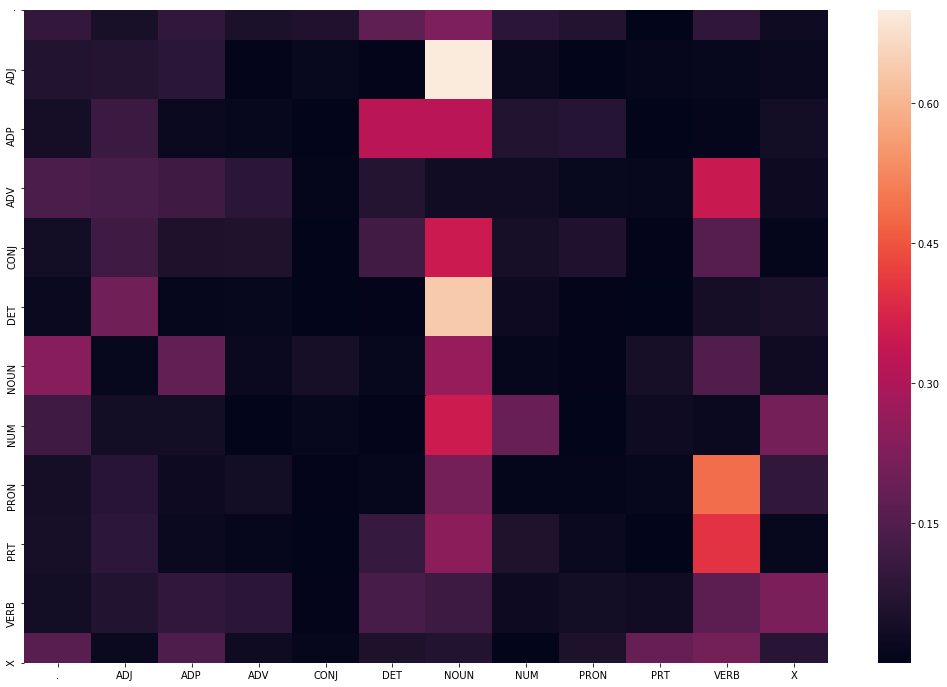

In [15]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

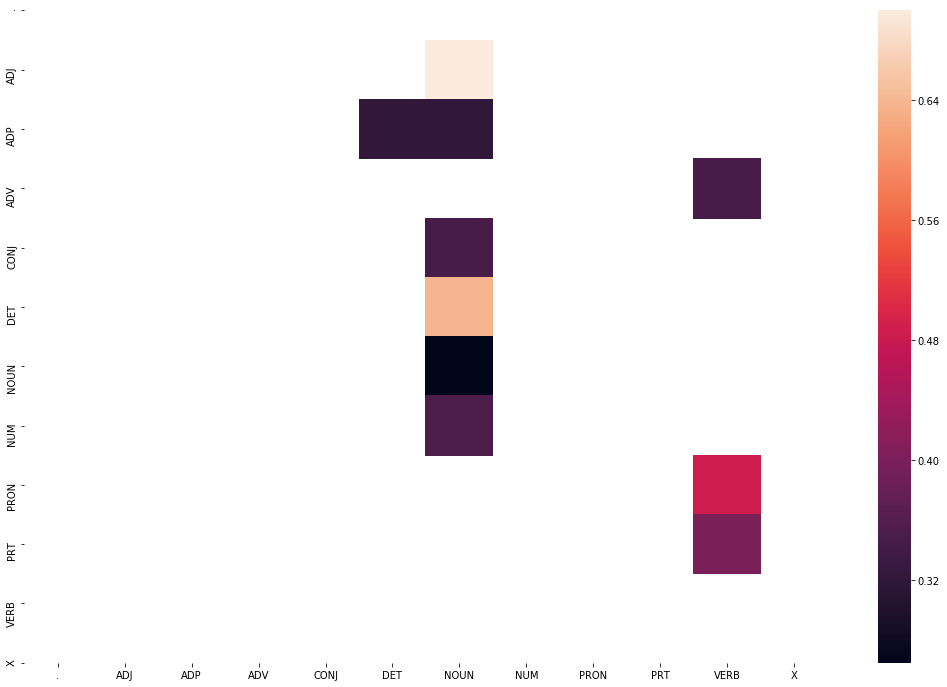

In [16]:
# frequent tags
# filter the df to get P(t2, t1) > 0.25
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [17]:
len(train_tagged_words)

96011

In [18]:
# Vanilla Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [19]:
# list of test sents
test_run = [test_set[i] for i in range(0,len(test_set))]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Faulding', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('it', 'PRON'),
  ('owns', 'VERB'),
  ('33', 'NUM'),
  ('%', 'NOUN'),
  ('of', 'ADP'),
  ('Moleculon', 'NOUN'),
  ("'s", 'PRT'),
  ('voting', 'NOUN'),
  ('stock', 'NOUN'),
  ('and', 'CONJ'),
  ('has', 'VERB'),
  ('an', 'DET'),
  ('agreement', 'NOUN'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('acquire', 'VERB'),
  ('an', 'DET'),
  ('additional', 'ADJ'),
  ('19', 'NUM'),
  ('%', 'NOUN'),
  ('.', '.')],
 [('The', 'DET'),
  ('government', 'NOUN'),
  ('includes', 'VERB'),
  ('money', 'NOUN'),
  ('spent', 'VERB'),
  ('*', 'X'),
  ('on', 'ADP'),
  ('residential', 'ADJ'),
  ('renovation', 'NOUN'),
  (';', '.'),
  ('Dodge', 'NOUN'),
  ('does', 'VERB'),
  ("n't", 'ADV'),
  ('*?*', 'X'),
  ('.', '.')],
 [('*', 'X'),
  ('Beginning', 'VERB'),
  ('in', 'ADP'),
  ('1980', 'NUM'),
  (',', '.'),
  ('courts', 'NOUN'),
  ('in', 'ADP'),
  ('several', 'ADJ'),
  ('states', 'NOUN'),
  ('including', 'VERB'),
  ('California', 'NOUN'),
  ('and', 'CONJ'),
  ('

In [20]:
# tagging the validation(test) sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  1366.1833539009094
[('Faulding', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('owns', 'VERB'), ('33', 'NUM'), ('%', 'NOUN'), ('of', 'ADP'), ('Moleculon', 'NOUN'), ("'s", 'PRT'), ('voting', 'NOUN'), ('stock', 'NOUN'), ('and', 'CONJ'), ('has', 'VERB'), ('an', 'DET'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('acquire', 'VERB'), ('an', 'DET'), ('additional', 'ADJ'), ('19', 'NUM'), ('%', 'NOUN'), ('.', '.'), ('The', 'DET'), ('government', 'NOUN'), ('includes', 'VERB'), ('money', 'NOUN'), ('spent', 'VERB'), ('*', 'X'), ('on', 'ADP'), ('residential', 'ADJ'), ('renovation', 'NOUN'), (';', '.'), ('Dodge', 'NOUN'), ('does', 'VERB'), ("n't", 'ADV'), ('*?*', 'X'), ('.', '.'), ('*', 'X'), ('Beginning', 'DET'), ('in', 'ADP'), ('1980', 'DET'), (',', '.'), ('courts', 'NOUN'), ('in', 'ADP'), ('several', 'ADJ'), ('states', 'NOUN'), ('including', 'VERB'), ('California', 'NOUN'), ('and', 'CONJ'), ('New', 'NOUN'), ('York', 'NOUN'), ('decided', 'VERB'), ('*-2', '

In [21]:
# Evaluating tagging accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = (len(check)/len(tagged_seq))*100
print('Accuracy: ',vanilla_viterbi_accuracy)

Accuracy:  91.31832797427653


In [22]:
# Getting incorrectly tagged words from validation set 
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('*', 'X'), (('Beginning', 'DET'), ('Beginning', 'VERB'))],
 [('in', 'ADP'), (('1980', 'DET'), ('1980', 'NUM'))],
 [('the', 'DET'), (('common-law', 'DET'), ('common-law', 'NOUN'))],
 [('.', '.'), (('Moreover', 'ADV'), ('Moreover', 'ADJ'))],
 [('the', 'DET'), (('1940s', 'DET'), ('1940s', 'NUM'))],
 [('synthetic', 'ADJ'), (('hormone', 'DET'), ('hormone', 'NOUN'))],
 [('hormone', 'NOUN'),
  (('diethylstilbestrol', 'DET'), ('diethylstilbestrol', 'NOUN'))],
 [('prevent', 'VERB'), (('miscarriages', 'DET'), ('miscarriages', 'NOUN'))],
 [('morning', 'NOUN'), (('sickness', 'DET'), ('sickness', 'NOUN'))],
 [('The', 'DET'), (('Internal', 'DET'), ('Internal', 'NOUN'))],
 [('who', 'PRON'), (('*T*-123', 'DET'), ('*T*-123', 'X'))],
 [('to', 'PRT'), (('report', 'NOUN'), ('report', 'VERB'))],
 [('report', 'VERB'), (('detailed', 'VERB'), ('detailed', 'ADJ'))],
 [('who', 'PRON'), (('*T*-124', 'DET'), ('*T*-124', 'X'))],
 [('*T*-124', 'X'), (('pay', 'NOUN'), ('pay', 'VERB'))],
 [('.', '.'), (('Prelimina

In [23]:
# Reading test sentences
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

In [24]:
# Running Vanilla Viterbi on Test Sentences
start = time.time()
tagged_seq_test = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq_test)
print("Time Taken : ", difference)

[('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'DET'), ("'s", 'VERB'), ('firehose', 'DET'), ('.', '.'), ('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NO

In [25]:
# Getting the unique list of words from Test Sentences which are not in Vocabulary
unknown_words = list(set([word for word in words if word not in V]))
print(unknown_words)
print("No. of Words: ", len(unknown_words))

['2015', 'personality', 'trips', '2013', 'arriving', 'Android', 'firehose', 'NASA', 'interact', 'Satellite', 'worldwide', 'Cup', 'FIFA', '21st', '2011', 'contested', 'Google', 'invited', 'OS', 'domineering', 'smartphones', 'tournament', 'ICESAT-2', 'messages', '2018', 'tweets', 'online', 'Twitter']
No. of Words:  28


In [26]:
# POS tag assigned to unknown words using vanilla viterbi 
unknown_list=[]
for i in range(len(tagged_seq_test)):
        if tagged_seq_test[i][0] in unknown_words:
            tags_for_word=[tagged_seq_test[i][0],tagged_seq_test[i][1]]
            unknown_list.append(tags_for_word)
unknown_list

[['Android', 'DET'],
 ['Google', 'DET'],
 ['Android', 'DET'],
 ['OS', 'DET'],
 ['worldwide', 'DET'],
 ['smartphones', 'DET'],
 ['2011', 'DET'],
 ['2013', 'DET'],
 ['Google', 'DET'],
 ['Twitter', 'DET'],
 ['2015', 'DET'],
 ['Google', 'DET'],
 ['Twitter', 'DET'],
 ['firehose', 'DET'],
 ['Twitter', 'DET'],
 ['online', 'DET'],
 ['interact', 'DET'],
 ['messages', 'DET'],
 ['tweets', 'DET'],
 ['domineering', 'DET'],
 ['personality', 'DET'],
 ['2018', 'DET'],
 ['FIFA', 'DET'],
 ['Cup', 'DET'],
 ['21st', 'DET'],
 ['FIFA', 'DET'],
 ['Cup', 'DET'],
 ['tournament', 'DET'],
 ['contested', 'DET'],
 ['Cup', 'DET'],
 ['trips', 'DET'],
 ['arriving', 'DET'],
 ['NASA', 'DET'],
 ['invited', 'DET'],
 ['ICESAT-2', 'DET'],
 ['Satellite', 'DET']]

### Solve the problem of unknown words

In [27]:
# Version 1 - Rule Based Tagging
# based on morphological cues following new rules are added using Regex Tagger to tag the unknown words correctly.

In [28]:
pattern = [
        (r'.*Twitter$', 'NOUN'), 
        (r'.*Android$', 'NOUN'),
        (r'.*Google$', 'NOUN'),
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number or float values
        (r'.*(ed|ing|ies|ied)$', 'VERB'), #words ending with ed,ing,ied,ies considered verbs
        (r'.*ould$', 'MD'),    # modals
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA etc
        (r'.*', 'NOUN') # default value as NOUN
]

def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        return v[1]

In [29]:
def Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [30]:
# tagging the test sentences
start = time.time()
tagged_seq_rule = Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq_rule)

Time taken in seconds:  1350.472990512848
[('Faulding', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('owns', 'VERB'), ('33', 'NUM'), ('%', 'NOUN'), ('of', 'ADP'), ('Moleculon', 'NOUN'), ("'s", 'PRT'), ('voting', 'NOUN'), ('stock', 'NOUN'), ('and', 'CONJ'), ('has', 'VERB'), ('an', 'DET'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('acquire', 'VERB'), ('an', 'DET'), ('additional', 'ADJ'), ('19', 'NUM'), ('%', 'NOUN'), ('.', '.'), ('The', 'DET'), ('government', 'NOUN'), ('includes', 'VERB'), ('money', 'NOUN'), ('spent', 'VERB'), ('*', 'X'), ('on', 'ADP'), ('residential', 'ADJ'), ('renovation', 'NOUN'), (';', '.'), ('Dodge', 'NOUN'), ('does', 'VERB'), ("n't", 'ADV'), ('*?*', 'X'), ('.', '.'), ('*', 'X'), ('Beginning', 'VERB'), ('in', 'ADP'), ('1980', 'NUM'), (',', '.'), ('courts', 'NOUN'), ('in', 'ADP'), ('several', 'ADJ'), ('states', 'NOUN'), ('including', 'VERB'), ('California', 'NOUN'), ('and', 'CONJ'), ('New', 'NOUN'), ('York', 'NOUN'), ('decided', 'VERB'), ('*-2', '

In [31]:
# Evaluating tagging accuracy
check_rule = [i for i, j in zip(tagged_seq_rule, test_run_base) if i == j] 
rulebased_viterbi_accuracy = (len(check_rule)/len(tagged_seq_rule))*100
print('Accuracy: ',rulebased_viterbi_accuracy)

Accuracy:  95.73419078242229


In [32]:
# Getting incorrectly tagged words from validation set 
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_rule, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('.', '.'), (('Moreover', 'ADV'), ('Moreover', 'ADJ'))],
 [('who', 'PRON'), (('*T*-123', 'NOUN'), ('*T*-123', 'X'))],
 [('to', 'PRT'), (('report', 'NOUN'), ('report', 'VERB'))],
 [('report', 'VERB'), (('detailed', 'VERB'), ('detailed', 'ADJ'))],
 [('who', 'PRON'), (('*T*-124', 'NOUN'), ('*T*-124', 'X'))],
 [('.', '.'), (('Preliminary', 'NOUN'), ('Preliminary', 'ADJ'))],
 [('Preliminary', 'ADJ'), (('tallies', 'VERB'), ('tallies', 'NOUN'))],
 [("'s", 'PRT'), (('export-oriented', 'VERB'), ('export-oriented', 'ADJ'))],
 [('funds', 'NOUN'), (('offer', 'NOUN'), ('offer', 'VERB'))],
 [('a', 'DET'), (('bread-and-butter', 'NOUN'), ('bread-and-butter', 'ADJ'))],
 [('.', '.'), (('Coincident', 'NOUN'), ('Coincident', 'ADJ'))],
 [('to', 'PRT'), (('open', 'ADJ'), ('open', 'VERB'))],
 [('biggest', 'ADJ'), (('wine-buying', 'VERB'), ('wine-buying', 'ADJ'))],
 [('holidays', 'NOUN'), (('approach', 'NOUN'), ('approach', 'VERB'))],
 [('.', '.'), (('Something', 'VERB'), ('Something', 'NOUN'))],
 [('the', 

In [33]:
# Running Rule based Viterbi on Test Sentences
start = time.time()
rulebased_test_tagged_seq = Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(rulebased_test_tagged_seq)
print("Time Taken : ", difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

In [34]:
# POS tag assigned to unknown words using rule based viterbi algorithm
unknown_list_rb=[]
for i in range(len(rulebased_test_tagged_seq)):
        if rulebased_test_tagged_seq[i][0] in unknown_words:
            tags_for_word=[rulebased_test_tagged_seq[i][0],rulebased_test_tagged_seq[i][1]]
            unknown_list_rb.append(rulebased_test_tagged_seq)
unknown_list_rb

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.'),
  ('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.'),
  ('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'ADP'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.'),
  ('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'NOUN'),
  ('news', 'NOUN'),
  ('and', 'CONJ'),

Accuracy of Rule Based Viterbi is higher than Vanilla Viterbi Algorithm

This technique correctly tags words like 
- 'Google, Twitter, Android' correctly as Nouns(NOUN)
- Verbs like contested, invited, arriving etc  as VERB
- Years 2011, 2013 as Numbers(NUM)

In [35]:
# Version 2 - Probabilistic Viterbi 
# Tagging with Maximum Transition Probaility - getting state with max transition probability for unknown words in vocabulary

def Viterbi_transition_prob_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # Initialise list of probability column for a given observation
        p = []
        trans_prob = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            
            # compute emission and state probabilities    
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p  
            
            p.append(state_probability)
            # storing transition_p in a list trans_prob to get the state with max transition probability for unknown words
            trans_prob.append(transition_p)
            
        pmax = max(p)
        
        # getting state for which probability is maximum 
        if pmax == 0.0: 
            state_max = T[trans_prob.index(max(trans_prob))]
        else:
            state_max = T[p.index(pmax)]
        
        state.append(state_max)
    return list(zip(words, state))



In [36]:
# tagging the test sentences
start = time.time()
tagged_seq_tp = Viterbi_transition_prob_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq_tp)

Time taken in seconds:  1361.264412164688
[('Faulding', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('owns', 'VERB'), ('33', 'NUM'), ('%', 'NOUN'), ('of', 'ADP'), ('Moleculon', 'NOUN'), ("'s", 'PRT'), ('voting', 'NOUN'), ('stock', 'NOUN'), ('and', 'CONJ'), ('has', 'VERB'), ('an', 'DET'), ('agreement', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('acquire', 'VERB'), ('an', 'DET'), ('additional', 'ADJ'), ('19', 'NUM'), ('%', 'NOUN'), ('.', '.'), ('The', 'DET'), ('government', 'NOUN'), ('includes', 'VERB'), ('money', 'NOUN'), ('spent', 'VERB'), ('*', 'X'), ('on', 'ADP'), ('residential', 'ADJ'), ('renovation', 'NOUN'), (';', '.'), ('Dodge', 'NOUN'), ('does', 'VERB'), ("n't", 'ADV'), ('*?*', 'X'), ('.', '.'), ('*', 'X'), ('Beginning', 'VERB'), ('in', 'ADP'), ('1980', 'DET'), (',', '.'), ('courts', 'NOUN'), ('in', 'ADP'), ('several', 'ADJ'), ('states', 'NOUN'), ('including', 'VERB'), ('California', 'NOUN'), ('and', 'CONJ'), ('New', 'NOUN'), ('York', 'NOUN'), ('decided', 'VERB'), ('*-2', '

In [37]:
# Evaluating tagging accuracy
check_tp = [i for i, j in zip(tagged_seq_tp, test_run_base) if i == j] 
TP_viterbi_accuracy = (len(check_tp)/len(tagged_seq_tp))*100
print('Accuracy: ',TP_viterbi_accuracy)

Accuracy:  94.7481243301179


In [38]:
# Getting incorrectly tagged words from validation set 
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_tp, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('in', 'ADP'), (('1980', 'DET'), ('1980', 'NUM'))],
 [('.', '.'), (('Moreover', 'ADV'), ('Moreover', 'ADJ'))],
 [('the', 'DET'), (('1940s', 'NOUN'), ('1940s', 'NUM'))],
 [('prevent', 'VERB'), (('miscarriages', 'X'), ('miscarriages', 'NOUN'))],
 [('who', 'PRON'), (('*T*-123', 'VERB'), ('*T*-123', 'X'))],
 [('to', 'PRT'), (('report', 'NOUN'), ('report', 'VERB'))],
 [('report', 'VERB'), (('detailed', 'VERB'), ('detailed', 'ADJ'))],
 [('who', 'PRON'), (('*T*-124', 'VERB'), ('*T*-124', 'X'))],
 [('.', '.'), (('Preliminary', 'NOUN'), ('Preliminary', 'ADJ'))],
 [("'s", 'PRT'), (('export-oriented', 'VERB'), ('export-oriented', 'ADJ'))],
 [('funds', 'NOUN'), (('offer', 'NOUN'), ('offer', 'VERB'))],
 [('a', 'DET'), (('bread-and-butter', 'NOUN'), ('bread-and-butter', 'ADJ'))],
 [('.', '.'), (('Coincident', 'NOUN'), ('Coincident', 'ADJ'))],
 [('to', 'PRT'), (('open', 'ADJ'), ('open', 'VERB'))],
 [('biggest', 'ADJ'), (('wine-buying', 'NOUN'), ('wine-buying', 'ADJ'))],
 [('holidays', 'NOUN'), (('a

In [39]:
# Running Transitional Probabilty based Viterbi on Test Sentences
start = time.time()
TP_test_tagged_seq = Viterbi_transition_prob_based(words)
end = time.time()
difference = end-start

print(TP_test_tagged_seq)
print("Time Taken : ", difference)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

In [40]:
# POS tag assigned to unknown words using transition probability based viterbi algorithm
unknown_list_tp=[]
for i in range(len(TP_test_tagged_seq)):
        if TP_test_tagged_seq[i][0] in unknown_words:
            tags_for_word=[TP_test_tagged_seq[i][0],TP_test_tagged_seq[i][1]]
            unknown_list_tp.append(TP_test_tagged_seq)
unknown_list_tp

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'DET'),
  ('.', '.'),
  ('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'DET'),
  ('since', 'ADP'),
  ('2011', 'DET'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'DET'),
  ('.', '.'),
  ('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'DET'),
  ('that', 'ADP'),
  ('gave', 'VERB'),
  ('Google', 'X'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'VERB'),
  ("'s", 'PRT'),
  ('firehose', 'VERB'),
  ('.', '.'),
  ('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'NOUN'),
  ('news', 'NOUN'),
  ('and', 'CONJ'),
  ('

Accuracy of this technique is more than Vanilla Viterbi but less than Rule Based Viterbi Algorithm.

This technique correctly tags words like
- 'Google, Twitter, Android' correctly as Nouns(NOUN)
- Abbrevations like FIFA, OS, NASA as Nouns
- Satellite, tournament as Nouns



### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [41]:
print("Vanilla Viterbi Accuracy: ", round(vanilla_viterbi_accuracy,2))
print("Rule Based Viterbi Accuracy: ", round(rulebased_viterbi_accuracy,2))
print("Transition Probability Based Viterbi Accuracy: ", round(TP_viterbi_accuracy,2))

Vanilla Viterbi Accuracy:  91.32
Rule Based Viterbi Accuracy:  95.73
Transition Probability Based Viterbi Accuracy:  94.75


#### Rule Based Viterbi Algorithm has the highest tagging accuracy on validation set

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [42]:
# POS tags by all algorithms for unknown words in the test sentences 
test_list=[]
for i in range(len(tagged_seq_test)):
        if tagged_seq_test[i][0] in unknown_words:
            tags_for_word=[tagged_seq_test[i][0],tagged_seq_test[i][1],rulebased_test_tagged_seq[i][1],TP_test_tagged_seq[i][1]]
            test_list.append(tags_for_word)

from IPython.display import HTML, display
import tabulate
headers = ['Word','POS tag (Vanilla Viterbi)','POS tag Technique-1(Rule Based)','POS tag Technique-2(Probabilistic)']
display(HTML(tabulate.tabulate(test_list,headers, tablefmt='html')))

Word,POS tag (Vanilla Viterbi),POS tag Technique-1(Rule Based),POS tag Technique-2(Probabilistic)
Android,DET,NOUN,NOUN
Google,DET,NOUN,DET
Android,DET,NOUN,NOUN
OS,DET,NOUN,NOUN
worldwide,DET,NOUN,NOUN
smartphones,DET,NOUN,DET
2011,DET,NUM,DET
2013,DET,NUM,DET
Google,DET,NOUN,NOUN
Twitter,DET,NOUN,NOUN


Words like 'Twitter', 'Android', 'Google' are correctly tagged with 'NOUN' in all modified Viterbi Algorithms

Words like 'NASA', 'FIFA' are correctly tagged as 'NOUN' in Rule Based Tagger (Cap words are abbrevations, hence generally a Noun) but not all were tagged correctly by Probabilistic Tagger.

Integers or float values are correctly tagged as 'NUM' in Rule Based Tagger but not with Probabilistic Tagger.

Words ending with '-ed' and '-ing' like 'invited', 'arriving', 'contested' etc are correctly tagged as 'VERB' in Rule Based Tagger but not with Probabilistic Tagger

#### Conclusion: Rule Based Tagger has better accuracy among three techniques and is able to tag more words correctly